### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import tensorflow_hub as hub

### Set all the Constants

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=100

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 529 files belonging to 9 classes.


In [5]:
class_names = dataset.class_names
class_names

['Bhimsen_Temple',
 'Char_Narayan_Temple',
 'Dhungey_Dhara',
 'Garuda_Pillar',
 'Harishankara_temple',
 'Krishna_Mandir',
 'Narayan_Temple',
 'Octagonal_Chyasing_Deval',
 'Vishwanath_Temple']

In [6]:
n_classes=len(class_names)
n_classes

9

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    print(image_batch[0])

(32, 128, 128, 3)
[8 7 1 5 0 2 7 5 0 2 8 7 8 2 8 1 8 4 5 4 1 2 1 5 3 5 4 0 8 4 0 8]
tf.Tensor(
[[[250.25     255.       254.0625  ]
  [251.       255.       254.      ]
  [253.       255.       254.      ]
  ...
  [140.80469  130.17969  118.17969 ]
  [147.17969  133.55469  127.86719 ]
  [169.79688  156.92578  147.88281 ]]

 [[249.9375   255.       255.      ]
  [251.       255.       254.      ]
  [251.       255.       254.3125  ]
  ...
  [150.875    142.875    129.875   ]
  [166.91016  157.91016  148.91016 ]
  [164.76172  154.76172  144.76172 ]]

 [[249.       255.       255.      ]
  [251.       255.       254.      ]
  [250.38672  254.38672  253.38672 ]
  ...
  [166.04297  156.04297  147.04297 ]
  [138.79688  125.796875 117.796875]
  [154.5      142.54297  130.69531 ]]

 ...

 [[ 92.88672  114.07422   81.01172 ]
  [ 55.210938  78.21094   52.210938]
  [ 83.33594  112.33594   82.02344 ]
  ...
  [147.69922  127.69922  116.69922 ]
  [143.7539   124.75391  109.75391 ]
  [147.41797  128.

As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

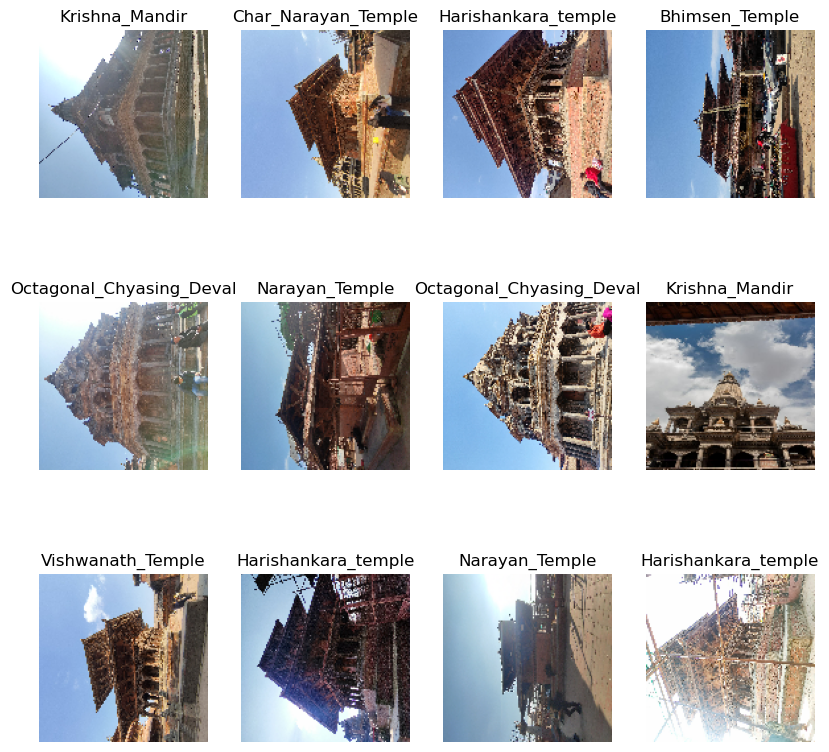

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [9]:
len(dataset)

17

In [10]:
train_size = 0.8
len(dataset)*train_size

13.600000000000001

In [11]:
train_ds = dataset.take(15)
len(train_ds)

15

In [12]:
test_ds = dataset.skip(15)
len(test_ds)

2

In [13]:
val_size=0.1
len(dataset)*val_size

1.7000000000000002

In [14]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [15]:
test_ds = test_ds.skip(1)
len(test_ds)

1

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

13

In [19]:
len(val_ds)

1

In [20]:
len(test_ds)

3

### Cache, Shuffle, and Prefetch the Dataset

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

#### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.


In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
])


#### Applying Data Augmentation to Train Dataset

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

##Now take pre-trained model and retrain it using monuments images

In [25]:
feature_extractor_model ="https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape= (IMAGE_SIZE, IMAGE_SIZE, CHANNELS), trainable=False)

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    layers.Input(shape=(None, None, 3)),
    resize_and_rescale,
    pretrained_model_without_top_layer, 
    layers.Dense(120, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(60, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(30, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax'),
])


In [27]:
#model.build()

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1001)              1692489   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 60)                7260      
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 30)               

In [29]:
# Get and print the weights of each layer
for layer in model.layers:
    if layer.get_weights():
        print(f"\nLayer: {layer.name}")
        weights = layer.get_weights()
        print(f"Weights:\n{weights}")
        
        # Check if biases exist
        if len(weights) > 1:
            biases = weights[1]
            print(f"Biases:\n{biases}")


Layer: keras_layer
Weights:
[array([[[[-2.69158870e-01,  8.65957048e-03, -2.40037894e-23,
          -3.73629987e-01, -8.38040039e-02, -3.97553414e-01,
          -8.82432014e-02, -2.70130157e-01,  5.13027050e-02,
          -3.79616916e-02, -8.09798762e-02,  1.18460335e-01,
          -2.62111515e-01, -4.75106128e-02, -2.70309061e-01,
          -1.89091021e-03,  1.93450060e-02, -1.84400603e-01,
           3.71257141e-02, -3.13959550e-03,  4.30672951e-02,
           5.30855246e-02,  2.03689888e-01, -4.15900350e-01,
           6.43603578e-02, -8.45911652e-02,  1.95204750e-01,
           5.53289652e-01, -7.00939670e-02,  2.48162802e-02,
           5.82158267e-02, -8.34867544e-03,  1.12488000e-02,
           2.01375082e-01,  1.65318623e-01,  5.29913092e-03,
           8.75912532e-02, -3.51472311e-02, -3.73357713e-01,
          -4.03537154e-02,  3.31574142e-01, -7.86787400e-23,
           1.26423925e-01, -1.21186465e-01,  1.04729570e-01,
          -2.50029657e-03, -4.56964523e-02, -1.49448708

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)


In [32]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
    #callbacks=[early_stopping]
)

Epoch 1/100
13/13 [==============================] - 87s 3s/step - loss: 2.3145 - accuracy: 0.1571 - val_loss: 1.8379 - val_accuracy: 0.3438
Epoch 2/100
13/13 [==============================] - 7s 513ms/step - loss: 1.8962 - accuracy: 0.3042 - val_loss: 1.7516 - val_accuracy: 0.3750
Epoch 3/100
13/13 [==============================] - 7s 508ms/step - loss: 1.6419 - accuracy: 0.4090 - val_loss: 1.5228 - val_accuracy: 0.4062
Epoch 4/100
13/13 [==============================] - 7s 536ms/step - loss: 1.5561 - accuracy: 0.3840 - val_loss: 1.3631 - val_accuracy: 0.5312
Epoch 5/100
13/13 [==============================] - 7s 536ms/step - loss: 1.4329 - accuracy: 0.4888 - val_loss: 1.2423 - val_accuracy: 0.4688
Epoch 6/100
13/13 [==============================] - 8s 579ms/step - loss: 1.2797 - accuracy: 0.5112 - val_loss: 1.1165 - val_accuracy: 0.5312
Epoch 7/100
13/13 [==============================] - 7s 545ms/step - loss: 1.2104 - accuracy: 0.5786 - val_loss: 1.0747 - val_accuracy: 0.6562
E

Epoch 58/100
13/13 [==============================] - 6s 419ms/step - loss: 0.4856 - accuracy: 0.8579 - val_loss: 0.2494 - val_accuracy: 0.9062
Epoch 59/100
13/13 [==============================] - 5s 415ms/step - loss: 0.4928 - accuracy: 0.8055 - val_loss: 0.2554 - val_accuracy: 0.9062
Epoch 60/100
13/13 [==============================] - 6s 421ms/step - loss: 0.4592 - accuracy: 0.8479 - val_loss: 0.3100 - val_accuracy: 0.8750
Epoch 61/100
13/13 [==============================] - 7s 548ms/step - loss: 0.4212 - accuracy: 0.8778 - val_loss: 0.2999 - val_accuracy: 0.8750
Epoch 62/100
13/13 [==============================] - 6s 421ms/step - loss: 0.4259 - accuracy: 0.8479 - val_loss: 0.2742 - val_accuracy: 0.8750
Epoch 63/100
13/13 [==============================] - 5s 413ms/step - loss: 0.4128 - accuracy: 0.8703 - val_loss: 0.2279 - val_accuracy: 0.9062
Epoch 64/100
13/13 [==============================] - 6s 421ms/step - loss: 0.3699 - accuracy: 0.8703 - val_loss: 0.2300 - val_accuracy:

In [34]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 0s 89ms/step - loss: 0.3810 - accuracy: 0.8750


In [35]:
scores

[0.3809816837310791, 0.875]

Scores is just a list containing loss and accuracy value

In [36]:
# Get and print the weights of each layer
for layer in model.layers:
    if layer.get_weights():
        print(f"\nLayer: {layer.name}")
        weights = layer.get_weights()
        print(f"Weights:\n{weights}")
        
        # Check if biases exist
        if len(weights) > 1:
            biases = weights[1]
            print(f"Biases:\n{biases}")


Layer: keras_layer
Weights:
[array([[[[-2.69158870e-01,  8.65957048e-03, -2.40037894e-23,
          -3.73629987e-01, -8.38040039e-02, -3.97553414e-01,
          -8.82432014e-02, -2.70130157e-01,  5.13027050e-02,
          -3.79616916e-02, -8.09798762e-02,  1.18460335e-01,
          -2.62111515e-01, -4.75106128e-02, -2.70309061e-01,
          -1.89091021e-03,  1.93450060e-02, -1.84400603e-01,
           3.71257141e-02, -3.13959550e-03,  4.30672951e-02,
           5.30855246e-02,  2.03689888e-01, -4.15900350e-01,
           6.43603578e-02, -8.45911652e-02,  1.95204750e-01,
           5.53289652e-01, -7.00939670e-02,  2.48162802e-02,
           5.82158267e-02, -8.34867544e-03,  1.12488000e-02,
           2.01375082e-01,  1.65318623e-01,  5.29913092e-03,
           8.75912532e-02, -3.51472311e-02, -3.73357713e-01,
          -4.03537154e-02,  3.31574142e-01, -7.86787400e-23,
           1.26423925e-01, -1.21186465e-01,  1.04729570e-01,
          -2.50029657e-03, -4.56964523e-02, -1.49448708

### Plotting the Accuracy and Loss Curves

In [37]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [38]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 13}

In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [40]:
type(history.history['loss'])

list

In [41]:
len(history.history['loss'])

100

In [42]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.3145289421081543,
 1.896207332611084,
 1.6419135332107544,
 1.5560541152954102,
 1.4328866004943848]

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

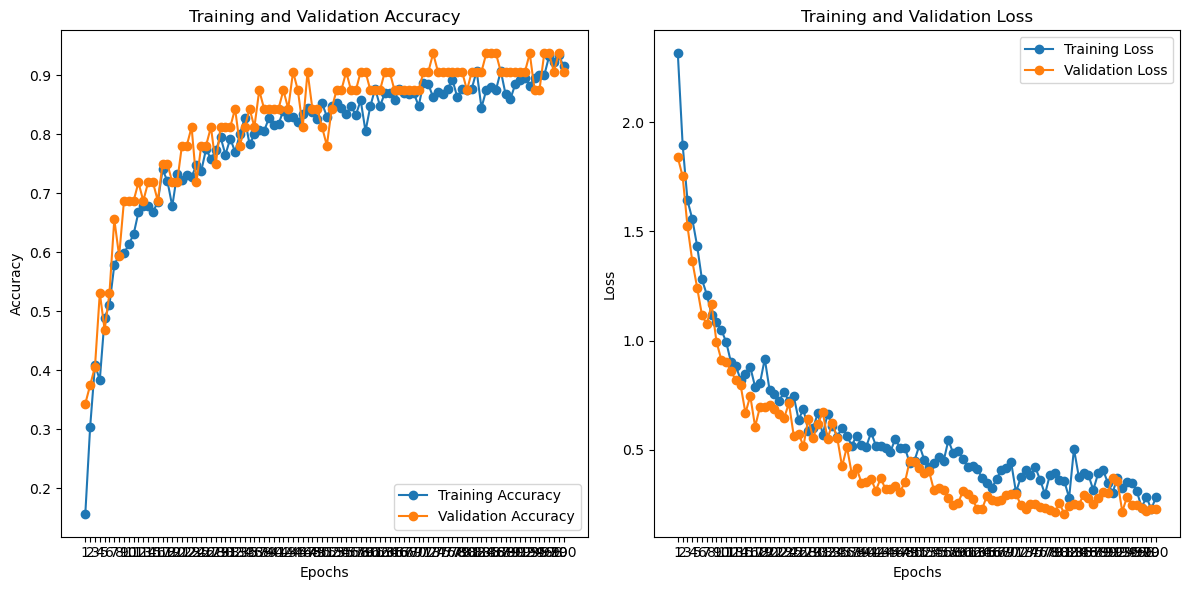

In [53]:
plt.figure(figsize=(12, 6))

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), acc, label='Training Accuracy', marker='o')
plt.plot(range(1, EPOCHS + 1), val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, EPOCHS + 1))

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), loss, label='Training Loss', marker='o')
plt.plot(range(1, EPOCHS + 1), val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, EPOCHS + 1))

plt.tight_layout()
plt.show()


### Run prediction on a sample image

[[[201 199 200]
  [190 189 189]
  [187 184 185]
  ...
  [189 188 186]
  [188 186 184]
  [184 182 183]]

 [[194 192 193]
  [189 187 186]
  [182 179 180]
  ...
  [195 193 191]
  [190 186 185]
  [184 182 183]]

 [[198 192 194]
  [188 185 185]
  [179 177 178]
  ...
  [195 192 193]
  [191 188 188]
  [194 185 188]]

 ...

 [[173 182 215]
  [175 182 212]
  [177 182 212]
  ...
  [228 218 223]
  [228 219 220]
  [228 219 219]]

 [[173 182 213]
  [172 186 215]
  [174 184 215]
  ...
  [229 220 222]
  [228 218 219]
  [222 217 214]]

 [[172 183 213]
  [172 188 214]
  [172 184 214]
  ...
  [227 218 219]
  [227 219 217]
  [222 218 214]]]
first image to predict
actual label: Dhungey_Dhara
1/1 [==============================] - 1s 859ms/step
predicted label: Dhungey_Dhara
2
tf.Tensor(
[[[255.       255.       255.      ]
  [255.       255.       255.      ]
  [255.       255.       255.      ]
  ...
  [ 75.375     69.52734   53.476562]
  [112.48828  109.48828   90.48828 ]
  [ 95.33203   94.44922   73.26

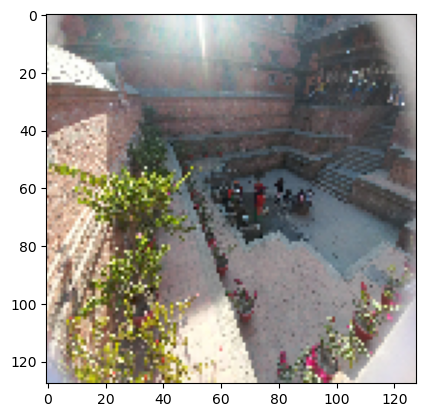

In [45]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print(first_image)
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    print(np.argmax(batch_prediction[0]))
    print(image_batch[0])

In [46]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the input image
img_path = r"C:\Users\pokha\monument_detection project\training\images\bouddhanath\istockphoto-1153332337-612x612.jpg"  # Replace with the actual path to your image
img = image.load_img(img_path, target_size=(128,128))  # Adjust target_size based on your model's input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize pixel values if needed


In [47]:
predictions1 = model.predict(img_array)

1/1 [==============================] - 1s 750ms/step


In [48]:
predicted_class = np.argmax(predictions1)


In [49]:
predicted_class


6

### Write a function for inference

In [50]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 39ms/step


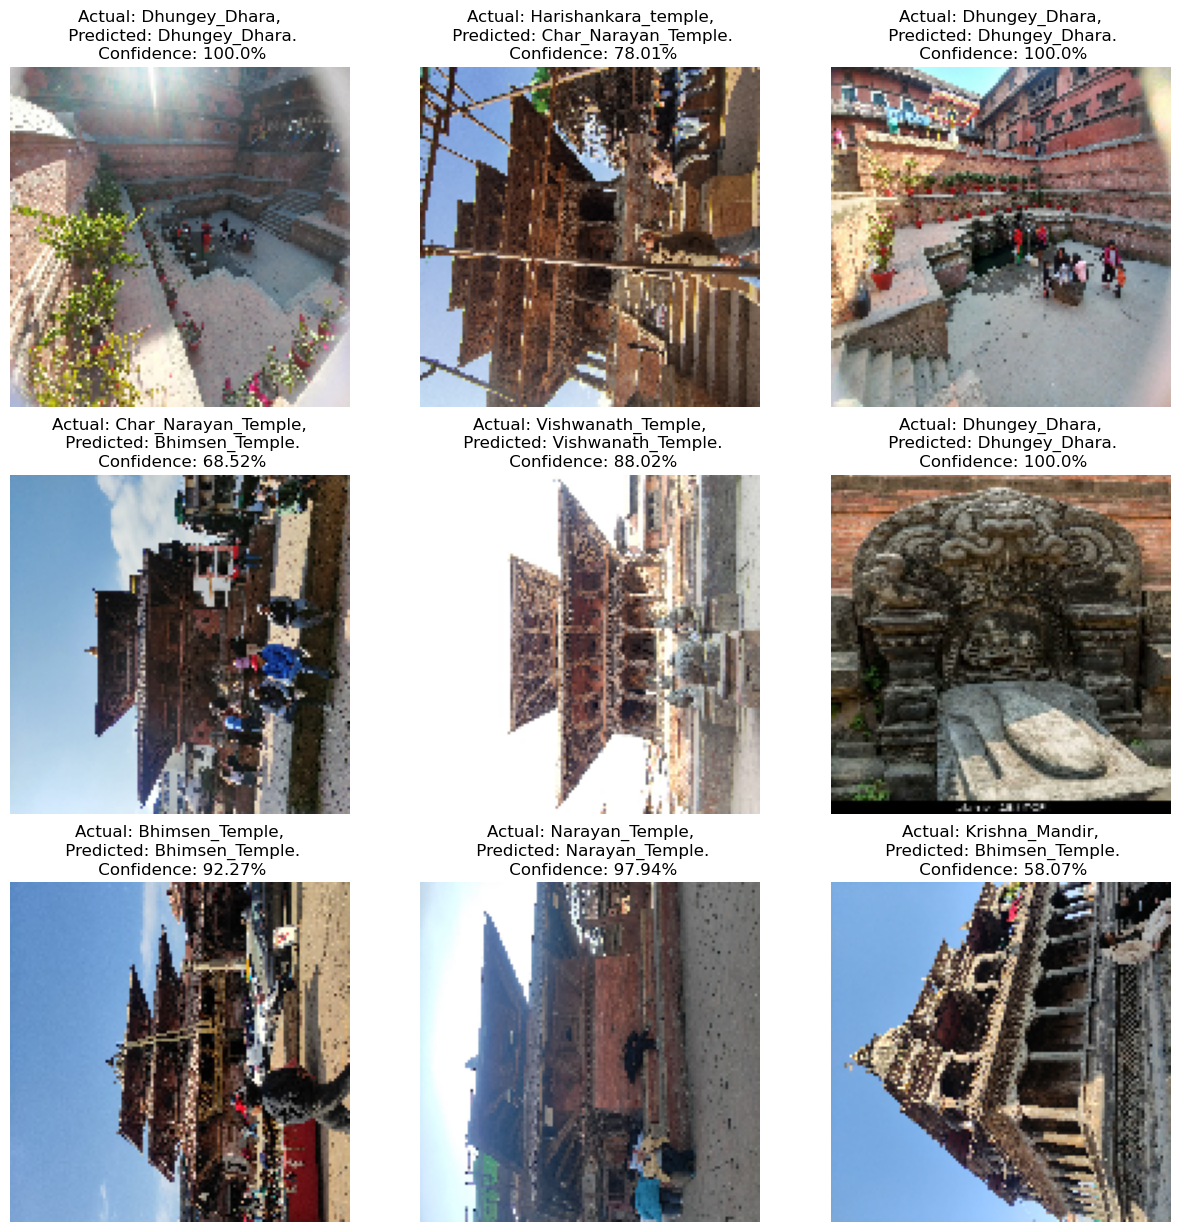

In [51]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [52]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/4\assets


INFO:tensorflow:Assets written to: ../saved_models/4\assets
